# Restoring Color to Greyscale Images

In [96]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes

import lasagne
import theano
import theano.tensor as T

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [100]:
imdir = "images/raw"
handles = os.listdir(imdir)
random.shuffle(handles)

## Playing Around with Shallow Regressors

In [40]:
def ShowColorAndGreyscale(color, grey):
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(color)
    ax2.imshow(grey, cmap=cm.gray)
    plt.show()

    
def ShowChannels(color, grey):
    _, axes = plt.subplots(1, 3)
    for ch in xrange(color.shape[2]):
        ax = axes[ch]
        ax.imshow(color[:, :, ch:ch + 1].reshape(
            grey.shape), cmap=cm.gray)
    plt.show()


def GeneratePatches(grey, stride):
    ymax, xmax = grey.shape
    stepmin, stepmax = ((stride - 1) / -2, stride / 2)
    steps = range(stepmin, stepmax + 1)
    trimmed_shape = (ymax - 2 * stepmax, xmax - 2 * stepmax)
    
    # convolutional patches for training
    # there's probably a numpy one-liner for this, but I don't know it
    patches = []
    for xoff in steps:
        for yoff in steps:
            patches.append(
                grey[stepmax + yoff:ymax - stepmax + yoff,
                     stepmax + xoff:xmax - stepmax + xoff])
    patches = np.stack(patches, axis=2)
    plt.imshow(patches.mean(axis=2), cmap=cm.gray)
    plt.show()
    return patches, trimmed_shape, len(steps) ** 2, xmax, ymax, stepmax


def RestoreImageFromFlattenedPatches(ch_clfs, flattened_patches, shape):
    channels = []
    for clf in ch_clfs:
        channels.append(clf.predict(flattened_patches).reshape(
            *shape))
    restored = np.stack(channels, axis=2)
    plt.imshow(restored)
    plt.show()
    return restored


def RestoreImage(ch_clfs, grey, stride):
    patches, trimmed_shape, num_features, _, _, _ = GeneratePatches(
        grey, stride)
    flattened_patches = patches.reshape(
        np.product(trimmed_shape), num_features)
    return RestoreImageFromFlattenedPatches(
        ch_clfs, flattened_patches, trimmed_shape)
    
    
def ModelChannels(color, grey, stride, clf_class, clf_kwargs):
    patches, trimmed_shape, num_features, xmax, ymax, stepmax = GeneratePatches(
        grey, stride)
    flattened_patches = patches.reshape(
        np.product(trimmed_shape), num_features)

    # models for each channel
    ch_clfs = []
    for ch in xrange(color.shape[2]):
        target_luminosities = color[
            stepmax:ymax - stepmax,
            stepmax:xmax - stepmax,
            ch].reshape(np.product(trimmed_shape))
        clf = clf_class(**clf_kwargs)
        clf.fit(flattened_patches, target_luminosities)
        ch_clfs.append(clf)
    
    RestoreImageFromFlattenedPatches(
        ch_clfs, flattened_patches, trimmed_shape)
    
    return ch_clfs


def ProcessImage(color, grey, stride,
                 clf_class=linear_model.LinearRegression, clf_kwargs={}):
    color = image.DownsampledPatch(color, 100, 100)
    grey = image.DownsampledPatch(grey, 100, 100)
    ShowColorAndGreyscale(color, grey)
    ShowChannels(color, grey)
    ch_clfs = ModelChannels(color, grey, stride, clf_class, clf_kwargs)
    return ch_clfs


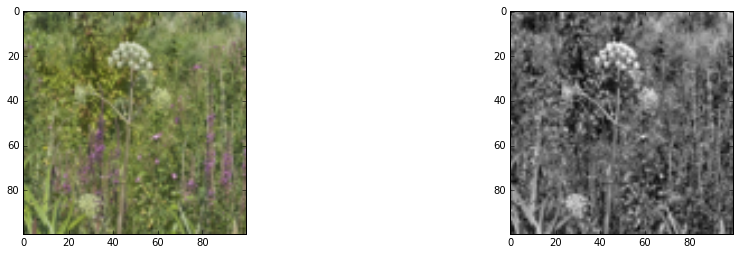

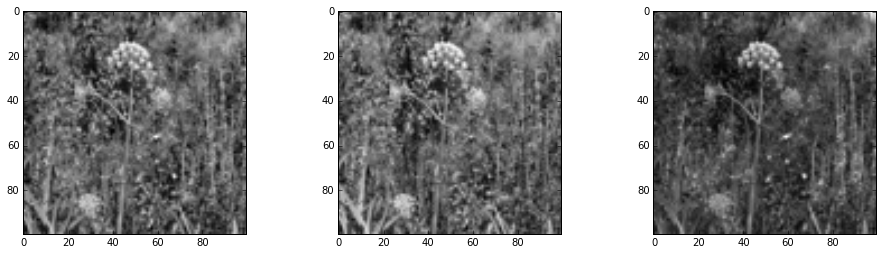

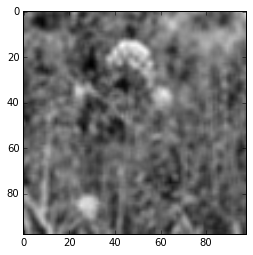

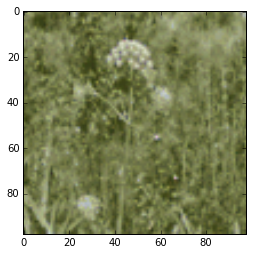

In [98]:
#color, grey = image.LoadColorAndGreyscaleImages(
#    os.path.join(imdir, handles[random.randint(0, len(handles))]))

ch_clfs = ProcessImage(
    color, grey, 3,
    clf_class=naive_bayes.GaussianNB)

## Neural Networks with Lasagne & Theano

based on the lasagne example code at https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py.

This is embarassingly copy-pasty. Will likely become more distinct as I grow to understand what I'm doing.


In [102]:
HEIGHT = 100
WIDTH = 100

fullsize = (
    image.LoadColorAndGreyscaleImages(os.path.join(imdir, h))
    for h in handles)

downsampled = [
    (image.DownsampledPatch(c, HEIGHT, WIDTH),
     image.DownsampledPatch(g, HEIGHT, WIDTH))
    for c, g in fullsize
    if c is not None and g is not None]

cannot identify image file 'images/raw/n02070430_1441.jpg'
Skipping greyscale image.
cannot identify image file 'images/raw/n06359193_10027.jpg'
cannot identify image file 'images/raw/n03724623_6171.jpg'
cannot identify image file 'images/raw/n01559477_1659.jpg'
Skipping greyscale image.
cannot identify image file 'images/raw/n11852028_5489.jpg'
Skipping greyscale image.
cannot identify image file 'images/raw/n03272383_3318.jpg'
cannot identify image file 'images/raw/n04305947_186.jpg'
cannot identify image file 'images/raw/n04517211_7881.jpg'
Skipping greyscale image.
cannot identify image file 'images/raw/n02745492_3640.jpg'
Skipping greyscale image.
Skipping greyscale image.
cannot identify image file 'images/raw/n03062122_12675.jpg'
cannot identify image file 'images/raw/n01533651_3837.jpg'
cannot identify image file 'images/raw/n02815749_1014.jpg'
cannot identify image file 'images/raw/n12076852_3860.jpg'
cannot identify image file 'images/raw/n03789400_1531.jpg'
cannot identify i

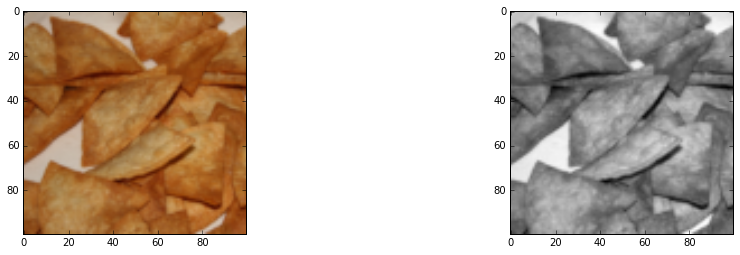

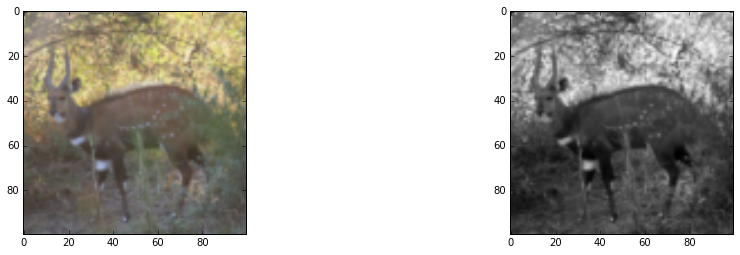

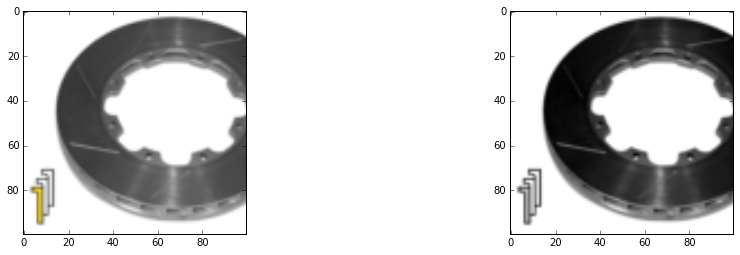

In [103]:
for c, g in downsampled[:3]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(c)
    ax2.imshow(g, cmap=cm.gray)

In [237]:
test_set_size = len(downsampled) / 10
test = downsampled[:test_set_size]
val = downsampled[test_set_size:2 * test_set_size]
train = downsampled[2 * test_set_size:]

X_test = np.array([g.reshape(HEIGHT, WIDTH, 1).T for _, g in test])
y_test = np.array([c.T for c, _ in test])
X_val = np.array([g.reshape(HEIGHT, WIDTH, 1).T for _, g in val])
y_val = np.array([c.T for c, _ in val])
X_train = np.array([g.reshape(HEIGHT, WIDTH, 1).T for _, g in train])
y_train = np.array([c.T for c, _ in train])

In [238]:
def BuildNet(input_var=None, height=HEIGHT, width=WIDTH, kernels=6, span=5):
    # We start with a single channel image, extract some number (>> 3) of
    # convolutional kernels, then collapse back down to 3 channels representing
    # red, green, and blue.
    l_in = lasagne.layers.InputLayer(
        shape=(None, 1, height, width),
        input_var=input_var)
    l_conv = lasagne.layers.Conv2DLayer(
        l_in,
        num_filters=kernels,
        filter_size=(span, span),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())
    l_out = lasagne.layers.Conv2DLayer(
        l_conv,
        num_filters=3,
        filter_size=(span, span),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())
    return l_out

In [264]:
def Minibatches(inputs, targets, batchsize, trim):
    assert len(inputs) == len(targets)
    for i in range(0, len(inputs) - batchsize + 1, batchsize):
        yield i, inputs[i:i + batchsize], targets[i:i + batchsize, :, trim:-trim, trim:-trim]


def CreateTheanoExprs(kernels=6, span=5, num_epochs=1, height=HEIGHT, width=WIDTH):
    # Inputs and outputs.
    # Input greyscale images need to be explicit H x W x 1 tensors of rank 3.
    # Leaving them as H x W matrices of rank 2 confuses lasagne's
    # convolutional logic.
    input_var = T.tensor4("inputs")
    target_var = T.tensor4("targets")

    # Build network.
    net = BuildNet(
        input_var=input_var,
        height=height,
        width=width,
        kernels=kernels,
        span=span)

    # Loss expression.
    # Since we don't have stochastic dropout, we can use the same loss
    # expr for training and validation. If we want to add a dropout layer,
    # then we need a separate loss expression for validation where stochastic
    # elements are explicitly frozen & dropout is disabled.
    prediction = lasagne.layers.get_output(net)
    loss = lasagne.objectives.squared_error(prediction, target_var).mean()

    # Weight updates during training.
    params = lasagne.layers.get_all_params(net, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
        loss,
        params,
        learning_rate=0.01,
        momentum=0.9)

    # Theano function to train a mini-batch.
    train_fn = theano.function(
        [input_var, target_var],
        loss,
        updates=updates)

    # Thano function to evaluate / validate on an input.
    # The difference between this and the training function is that the
    # test / validation function does not apply weight updates.
    val_fn = theano.function(
        [input_var, target_var],
        loss)
    
    return (input_var, target_var,
            net, prediction, loss, params, updates,
            train_fn, val_fn)


def Train(num_epochs, batch_size, trim,
          X_train, y_train, X_val, y_val, X_test, y_test,
          input_var, target_var,
          net, prediction, loss, params, updates,
          train_fn, val_fn):
    # Record stats for each epoch
    epochs = []
    
    # Run through training data for each epoch
    for epoch in xrange(num_epochs):
        # Train
        mark = time.time()
        train_errs = []
        iterator = Minibatches(X_train, y_train, batch_size, trim)
        for i, inputs, targets in iterator:
            print "Training batch starting at {i}...".format(i=i)
            train_errs.append(train_fn(inputs, targets))
        train_err = np.mean(train_errs)
        train_time = time.time() - mark
        
        # Validate
        mark = time.time()
        val_errs = []
        iterator = Minibatches(X_val, y_val, batch_size, trim)
        for i, inputs, targets in iterator:
            print "Validating batch starting at {i}...".format(i=i)
            val_errs.append(val_fn(inputs, targets))
        val_err = np.mean(val_errs)
        val_time = time.time() - mark
        
        # Record & report metrics
        epochs.append((epoch, train_time, val_time, train_err, val_err))
        print ("\nFinished Epoch {epoch}:\n"
               "- training took {train_time:.2f} seconds\n"
               "- validation took {val_time:.2f} seconds\n"
               "- training error = {t_err:.2f}\n"
               "- validation error = {v_err:.2f}\n").format(
                   epoch=epoch,
                   train_time=train_time,
                   val_time=val_time,
                   t_err=train_err,
                   v_err=val_err)

    return epochs, net

In [265]:
theano_exprs = CreateTheanoExprs()

In [268]:
epochs, net = Train(
    10, 500, 4,
    X_train, y_train, X_val, y_val, X_test, y_test,
    *theano_exprs)

Training batch starting at 0...
Training batch starting at 500...
Training batch starting at 1000...
Training batch starting at 1500...
Training batch starting at 2000...
Training batch starting at 2500...
Training batch starting at 3000...
Training batch starting at 3500...
Validating batch starting at 0...
Finished Epoch 0:
- training took 35.65 seconds
- validation took 1.14 seconds
- training error = 17582.19
- validation error = 17635.94
Training batch starting at 0...
Training batch starting at 500...
Training batch starting at 1000...
Training batch starting at 1500...
Training batch starting at 2000...
Training batch starting at 2500...
Training batch starting at 3000...
Training batch starting at 3500...
Validating batch starting at 0...
Finished Epoch 1:
- training took 35.98 seconds
- validation took 1.15 seconds
- training error = 17582.19
- validation error = 17635.94
Training batch starting at 0...
Training batch starting at 500...
Training batch starting at 1000...
Train

In [269]:
epochs

[(0,
  35.650288105010986,
  1.1448009014129639,
  17582.194366246342,
  17635.941572642863),
 (1,
  35.97857189178467,
  1.1494150161743164,
  17582.194369085035,
  17635.941571757907),
 (2,
  37.636943101882935,
  1.1374928951263428,
  17582.194365724259,
  17635.94156319942),
 (3,
  37.20548892021179,
  1.1825759410858154,
  17582.194365265274,
  17635.941575749897),
 (4,
  37.11274814605713,
  1.1865129470825195,
  17582.194364576764,
  17635.941563203025),
 (5,
  41.31978917121887,
  1.307955026626587,
  17582.19436606473,
  17635.941573681022),
 (6,
  41.80417513847351,
  1.3112690448760986,
  17582.19436569848,
  17635.941574274566),
 (7,
  38.97601079940796,
  1.1732051372528076,
  17582.194363295963,
  17635.941568088751),
 (8,
  40.08258509635925,
  1.2115130424499512,
  17582.194367274162,
  17635.941586475576),
 (9,
  38.332355976104736,
  1.1673519611358643,
  17582.194364329931,
  17635.94156963129)]